In [119]:
from datetime import datetime, timedelta
import yfinance as yf

In [129]:
from packages.models.indicators.IndicatorType import IndicatorType
from packages.models.Indicator import Indicator

In [158]:
import pandas as pd
import matplotlib.pyplot as plt

### Indicador do Raul, para teste.
(Ajustado)


In [63]:
class MaxValueLast365days:
    id = IndicatorType.maxValueLast365days
    name = 'maxValueLast365days'
    description = 'Maior valor nos últimos 365 dias'

    def __init__(self):
        pass


    def calculate(self,stocks=[]):
        today = datetime.today()
        last_yeah = today - timedelta(days=365)
        data = yf.download(stocks, last_yeah.strftime('%Y-%m-%d'), today.strftime('%Y-%m-%d'))
        self.data = data #Para checagem.

        result = []
        for stock in stocks:
            stock_max_value = 0
            stock_last_close = data['Close'][stock][-1] if len(stocks) > 1 else data['Close'][-1]
            for val in data['Close'][stock] if len(stocks) > 1 else data['Close']:
                if val > stock_max_value:
                    stock_max_value = val

            indicator = Indicator(id=MaxValueLast365days.id,
                                  name=MaxValueLast365days.name,
                                  asset_name=stock,
                                  description=MaxValueLast365days.description,
                                  indicator_value=stock_max_value,
                                  current_value=stock_last_close,
                                  potential=1 - (stock_last_close / stock_max_value),
                                  unit='BRL',
                                  last_update=datetime.today().strftime('%Y-%m-%d'),
                                  past_horizon=last_yeah.strftime('%Y-%m-%d'),
                                  future_horizon=today.strftime('%Y-%m-%d'))

            result.append(indicator) #Para checagem.
            self.result = result

        return result

In [64]:
# Realização do Calculo
ind = MaxValueLast365days()
ind.calculate(['ABEV3.SA','PETR4.SA'])

[*********************100%***********************]  2 of 2 completed


In [65]:
print(', '.join("%s: %s" % item for item in vars(ind1.result[0]).items()))
print()
print(', '.join("%s: %s" % item for item in vars(ind1.result[1]).items()))


id: 1, name: maxValueLast365days, asset_name: ABEV3.SA, description: Maior valor nos últimos 365 dias, current_value: 13.960000038146973, indicator_value: 20.6299991607666, potential: 0.3233155304874852, unit: BRL, last_update: 2020-06-12, past_horizon: 2019-06-13, future_horizon: 2020-06-12

id: 1, name: maxValueLast365days, asset_name: PETR4.SA, description: Maior valor nos últimos 365 dias, current_value: 21.399999618530273, indicator_value: 30.969999313354492, potential: 0.3090087151115165, unit: BRL, last_update: 2020-06-12, past_horizon: 2019-06-13, future_horizon: 2020-06-12


### Indicador de Recuperação
A proposta deste indicador é verificar como está a recuperação da empresa.

Baseado no quanto ela já teve de valor e namaior queda da mesma. (só faz sentido em cenário de recuperação de crise).

O quanto que ela já recuperou?
(serve de base para o indicador seguinte, recuperação relativa)

In [147]:
assets = ['ITUB4.SA','B3SA3.SA','PETR4.SA','BBDC4.SA','PETR3.SA','ABEV3.SA', 'BBAS3.SA','ITSA4.SA','MGLU3.SA','JBSS3.SA']
today = datetime.today()
first_day = today - timedelta(days=365)
df = yf.download(assets, first_day.strftime('%Y-%m-%d'), today.strftime('%Y-%m-%d'))

[*********************100%***********************]  10 of 10 completed


In [150]:
#para auxiliar nesta apresentação
results = []

#logica
for asset in assets:
    last_close = df['Close'][asset][-1]
    max_value = df['Close'][asset].max()
    min_value = df['Close'][asset].min()
    recovery_degree =  (last_close-min_value)/(max_value-min_value)

    #para auxiliar nesta apresentação
    results.append(recovery_degree)

results_ser = pd.Series(data=results, index=assets)
results_ser.round(2).sort_values()

BBDC4.SA    0.22
ABEV3.SA    0.31
JBSS3.SA    0.32
ITUB4.SA    0.35
BBAS3.SA    0.37
ITSA4.SA    0.37
PETR3.SA    0.49
PETR4.SA    0.51
B3SA3.SA    0.89
MGLU3.SA    0.93
dtype: float64

Podemos perceber que ações como B3 e MGLU já recuperaram quase todo seu valor, enquanto as demais ações estão bastante distantes do valor original.

### Código proposto no modelo (não funcional)

In [143]:
# class RecoveryDegree():
#     id = IndicatorType.recoveryDegree
#     name = 'recoveryDegree'
#     description = 'Grau de recuperação em função de maior valor e maior queda no horizonte considerado'
    
#     def __init__(self):
#         pass


#     def calculate(self,stocks=[]):
#         today = datetime.today()
#         first_day = today - timedelta(days=365)
#         df = yf.download(assets, first_day.strftime('%Y-%m-%d'), today.strftime('%Y-%m-%d'))

#         for asset in assets:
#             last_close = df['Close'][asset][-1]
#             max_value = df['Close'][asset].max()
#             min_value = df['Close'][asset].min()
#             recovery_degree =  (last_close-min_value)/(max_value-min_value)           

#             indicator = Indicator(id=RecoveryDegree.id,
#                               name=RecoveryDegree.name,
#                               asset_name=asset,
#                               description=RecoveryDegree.description,
#                               indicator_value=recovery_degree,
#                               current_value=last_close,
#                               potential='',
#                               unit='BRL',
#                               last_update=datetime.today().strftime('%Y-%m-%d'),
#                               past_horizon=last_year.strftime('%Y-%m-%d'),
#                               future_horizon=today.strftime('%Y-%m-%d'))

#             result.append(indicator)

#         return recovery_degree

### Indicador de Recuperação relativa
A proposta deste indicador é verificar como está a recuperação da ação com base no mercado.
Ou seja, o quanto a ação já se recuperou com base no mercado como um todo.
Ela se recuperou mais? menos? O quanto?


In [153]:
assets = ['ITUB4.SA','B3SA3.SA','PETR4.SA','BBDC4.SA','PETR3.SA','ABEV3.SA', 'BBAS3.SA','ITSA4.SA','MGLU3.SA','JBSS3.SA']
assets_and_IBOV = ['^BVSP']+ assets
today = datetime.today()
first_day = today - timedelta(days=365)
df = yf.download(assets_and_IBOV, first_day.strftime('%Y-%m-%d'), today.strftime('%Y-%m-%d'))

[*********************100%***********************]  11 of 11 completed


In [154]:
#para auxiliar nesta apresentação
results = []

#logica

def recovery_degree_calc(asset):
    last_close = df['Close'][asset][-1]
    max_value = df['Close'][asset].max()
    min_value = df['Close'][asset].min()
    recovery_degree =  (last_close-min_value)/(max_value-min_value)
    return recovery_degree

ibov_rec_degree = recovery_degree_calc('^BVSP')
for asset in assets:
    recovery_degree = recovery_degree_calc(asset)
    relative_recovery_degree = recovery_degree/ibov_rec_degree

    #para auxiliar nesta apresentação
    results.append(relative_recovery_degree)

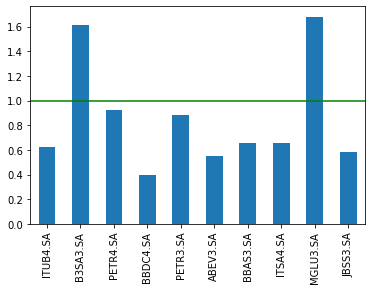

In [162]:
# para visualizar
plt.axhline(y=1,color ='green')
results_ser = pd.Series(data=results, index=assets)
results_ser.plot.bar()


Utilidade???? 

### Código proposto no modelo (não funcional)